# Method Comparison: SR3, STLSQ, and LASSO

This notebook performs SR3, sequentially thresholded least squares (STLSQ), and LASSO on example data from the Lorenz system.

In [1]:
import sys
import numpy as np
from scipy.integrate import odeint

import pysindy as ps
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

sys.path.insert(0, '..')
from utils import *

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Generate Lorenz training data

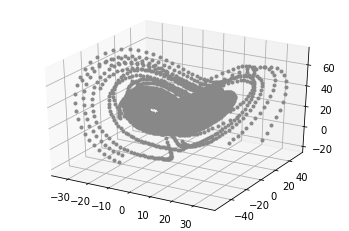

In [2]:
np.random.seed(1)

# time grid set up
ts = 0.0
te = 10.0
dt = .005
t = np.arange(ts,te,dt)

# ode set up
lorenz = lambda z,t : [10*(z[1] - z[0]), z[0]*(28 - z[2]) - z[1], z[0]*z[1] - 8/3*z[2]]

# generate training data
n_trajectories = 20
x0s = 2*np.array([36,48,41])*(np.random.rand(n_trajectories, 3)-.5) + np.array([0,0,25])
x = []
for i in range(n_trajectories):
    x.append(odeint(lorenz, x0s[i], t))
x_noisy = add_noise(x, std=1e-2)
    
# generate test trajectories
x_test1 = odeint(lorenz, [-8.,7.,27.], t)
x_test2 = odeint(lorenz, [0.01,0.01,60.], t)
    
# true coefficient matrix
true_coefficients = np.zeros((10,3))
true_coefficients[1,0] = -10
true_coefficients[2,0] = 10
true_coefficients[1,1] = 28
true_coefficients[2,1] = -1
true_coefficients[6,1] = -1
true_coefficients[3,2] = -8/3
true_coefficients[5,2] = 1

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(n_trajectories):
    ax.plot(x[i][:,0],x[i][:,1],x[i][:,2],'.', color='#888888')

## Fit each model

In [3]:
threshold = 0.1
nu = 1
library = ps.PolynomialLibrary(degree=3)

In [4]:
# SR3

optimizer_sr3 = ps.SR3(threshold=threshold, nu=nu)
model_sr3 = ps.SINDy(optimizer=optimizer_sr3, feature_library=library, feature_names=['x','y','z'])
model_sr3.fit(x_noisy, t=dt, multiple_trajectories=True)
model_sr3.print()

x' = -9.991 x + 9.991 y
y' = 27.905 x + -0.982 y + -0.997 x z
z' = -2.661 z + 0.998 x y


In [5]:
# STLSQ

optimizer_stlsq = ps.STLSQ(threshold=threshold)
model_stlsq = ps.SINDy(optimizer=optimizer_stlsq, feature_library=library, feature_names=['x','y','z'])
model_stlsq.fit(x_noisy, t=dt, multiple_trajectories=True)
model_stlsq.print()

x' = -9.991 x + 9.991 y
y' = 27.905 x + -0.982 y + -0.997 x z
z' = -2.661 z + 0.998 x y


In [6]:
# LASSO, alpha=0.1

optimizer_lasso_smalla = Lasso(fit_intercept=False, alpha=0.1, max_iter=5000)
model_lasso_smalla = ps.SINDy(optimizer=optimizer_lasso_smalla, feature_library=library,
                                 feature_names=['x','y','z'])
model_lasso_smalla.fit(x_noisy, t=dt, multiple_trajectories=True)
model_lasso_smalla.print()

x' = -10.028 x + 10.017 y + 0.001 x z
y' = 28.066 x + -1.020 y + -0.001 z + 0.001 x^2 + -0.002 x y + -1.006 x z + 0.001 y^2 + 0.001 y z
z' = -2.658 z + 1.002 x y


In [7]:
# LASSO, alpha=50

optimizer_lasso_biga = Lasso(fit_intercept=False, alpha=50, max_iter=5000)
model_lasso_biga = ps.SINDy(optimizer=optimizer_lasso_biga, feature_library=library,
                                 feature_names=['x','y','z'])
model_lasso_biga.fit(x_noisy, t=dt, multiple_trajectories=True)
model_lasso_biga.print()

x' = -0.310 x y + -0.404 x z + 0.157 y^2 + 0.462 y z + 0.015 z^2 + -0.001 x^3 + 0.007 x^2 y + 0.001 x^2 z + -0.006 x y^2 + 0.006 x y z + 0.004 x z^2 + 0.003 y^3 + -0.003 y^2 z + -0.006 y z^2
y' = 9.776 y + 0.489 x y + 0.186 x z + -0.237 y^2 + -0.291 y z + -0.030 z^2 + 0.005 x^3 + -0.010 x^2 y + -0.003 x^2 z + 0.007 x y^2 + -0.009 x y z + -0.013 x z^2 + -0.002 y^3 + 0.005 y^2 z + 0.002 y z^2 + 0.001 z^3
z' = 0.350 x^2 + 0.849 x y + -0.023 y^2 + -0.174 z^2 + -0.009 x^2 z + 0.004 x y z + 0.003 z^3


## Plot simulation results, coefficient matrices

(-99.95, 2098.95, -19.277071176944037, 18.175408761089706)

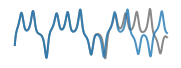

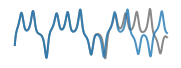

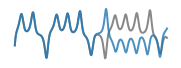

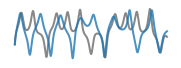

In [8]:
# on attractor test trajectory

plt.figure(figsize=(3,1))
plt.plot(x_test1[:,0], color='#888888', linewidth=2)
plt.plot(model_stlsq.simulate(x_test1[0],t)[:,0], linewidth=2, alpha=0.8)
plt.axis('off')
# plt.savefig('simulation_tls.pdf', dpi=600)

plt.figure(figsize=(3,1))
plt.plot(x_test1[:,0], color='#888888', linewidth=2)
plt.plot(model_sr3.simulate(x_test1[0],t)[:,0], linewidth=2, alpha=0.8)
plt.axis('off')
# plt.savefig('simulation_sr3.pdf', dpi=600)

plt.figure(figsize=(3,1))
plt.plot(x_test1[:,0], color='#888888', linewidth=2)
plt.plot(model_lasso_smalla.simulate(x_test1[0],t)[:,0], linewidth=2, alpha=0.8)
plt.axis('off')
# plt.savefig('simulation_lasso_small.pdf', dpi=600)

plt.figure(figsize=(3,1))
plt.plot(x_test1[:,0], color='#888888', linewidth=2)
plt.plot(model_lasso_biga.simulate(x_test1[0],t)[:,0], linewidth=2, alpha=0.8)
plt.axis('off')
# plt.savefig('simulation_lasso_big.pdf', dpi=600)

(-99.95, 2098.95, -21.501620060180933, 16.750339812561005)

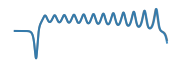

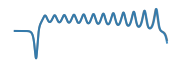

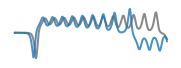

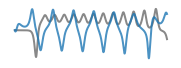

In [9]:
# off attractor test trajectory

plt.figure(figsize=(3,1))
plt.plot(x_test2[:,0], color='#888888', linewidth=2)
plt.plot(model_stlsq.simulate(x_test2[0],t)[:,0], linewidth=2, alpha=0.8)
plt.axis('off')
# plt.savefig('simulation2_tls.pdf', dpi=600)

plt.figure(figsize=(3,1))
plt.plot(x_test2[:,0], color='#888888', linewidth=2)
plt.plot(model_sr3.simulate(x_test2[0],t)[:,0], linewidth=2, alpha=0.8)
plt.axis('off')
# plt.savefig('simulation2_sr3.pdf', dpi=600)

plt.figure(figsize=(3,1))
plt.plot(x_test2[:,0], color='#888888', linewidth=2)
plt.plot(model_lasso_smalla.simulate(x_test2[0],t)[:,0], linewidth=2, alpha=0.8)
plt.axis('off')
# plt.savefig('simulation2_lasso_small.pdf', dpi=600)

plt.figure(figsize=(3,1))
plt.plot(x_test2[:,0], color='#888888', linewidth=2)
plt.plot(model_lasso_biga.simulate(x_test2[0],t)[:,0], linewidth=2, alpha=0.8)
plt.axis('off')
# plt.savefig('simulation2_lasso_big.pdf', dpi=600)

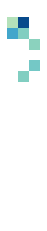

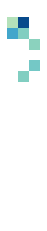

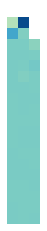

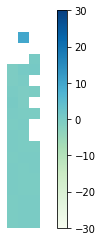

In [10]:
# coefficient matrices

clims = [-30,30]
cmap = cm.GnBu

plt.figure()
plt.imshow(sigma_plot_sparsity(model_stlsq.coefficients().T), interpolation='nearest', cmap=cmap)
plt.clim(clims)
plt.axis('off')
# plt.savefig('coefficients_tls.pdf', dpi=600)

plt.figure()
plt.imshow(sigma_plot_sparsity(model_sr3.coefficients().T), interpolation='nearest', cmap=cmap)
plt.clim(clims)
plt.axis('off')
# plt.savefig('coefficients_sr3.pdf', dpi=600)

plt.figure()
plt.imshow(sigma_plot_sparsity(model_lasso_smalla.coefficients().T), interpolation='nearest', cmap=cmap)
plt.clim(clims)
plt.axis('off')
# plt.savefig('coefficients_lasso_small.pdf', dpi=600)

plt.figure()
plt.imshow(sigma_plot_sparsity(model_lasso_biga.coefficients().T), interpolation='nearest', cmap=cmap)
plt.clim(clims)
plt.axis('off')
plt.colorbar()
# plt.savefig('coefficients_lasso_big.pdf', dpi=600)

(10, 60)

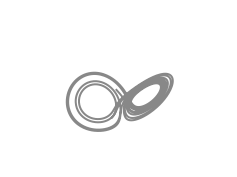

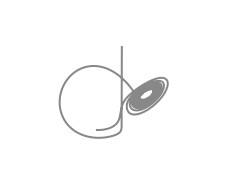

In [11]:
# plot true on attractor test trajectory - 3D
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_test1[:,0],x_test1[:,1],x_test1[:,2], color='#888888', linewidth=2)
plt.axis('off')
ax.set_xlim3d([-30,30])
ax.set_ylim3d([-25,25])
ax.set_zlim3d([10,60])
# fig.savefig('lorenz_sim.pdf', dpi=600)

# plot true off attractor test trajectory - 3D
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_test2[:,0],x_test2[:,1],x_test2[:,2], color='#888888', linewidth=2)
plt.axis('off')
ax.set_xlim3d([-30,30])
ax.set_ylim3d([-25,25])
ax.set_zlim3d([10,60])
# fig.savefig('lorenz_sim2.pdf', dpi=600)

## Compare performance for test data, both on and off attractor

In [12]:
# generate test data - on attractor

ts = 0.0
te = 5.0
dt = .005
t = np.arange(ts,te,dt)

n_trajectories = 50
x0s = 2*np.array([36,48,41])*(np.random.rand(n_trajectories, 3)-.5) + np.array([0,0,25])
x_test_on = []
for i in range(n_trajectories):
    x_test_on.append(odeint(lorenz, x0s[i], t))
x_test_on = np.array(add_noise(x_test_on, std=1e-2))

scores_on = []
for model in [model_sr3, model_stlsq, model_lasso_smalla, model_lasso_biga]:
    sims = []
    for i in range(n_trajectories):
        sims.append(model.simulate(x_test_on[i,0],t))
    scores_on.append(r2_score(x_test_on.reshape((-1,3)), np.array(sims).reshape((-1,3))))

/Users/kpchamp/opt/anaconda3/envs/py3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/kpchamp/opt/anaconda3/envs/py3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/kpchamp/opt/anaconda3/envs/py3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/kpchamp/opt/anaconda3/envs/py3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_

In [13]:
model_names = ['SR3', 'STLSQ', 'LASSO, alpha=0.1', 'LASSO, alpha=50']
print('On attractor R-squared scores')
for i,score in enumerate(scores_on):
    print('%s: %f' % (model_names[i],score))

On attractor R-squared scores:
SR3: 0.820186
STLSQ: 0.820186
LASSO, alpha=0.1: 0.833274
LASSO, alpha=50: -1320081274.224410


In [14]:
# generate test data - off attractor
ts = 0.0
te = 5
dt = .005
t_off = np.arange(ts,te,dt)

inDist_ic_widths = np.array([36,48,41])
outDist_extra_width = np.array([18,24,20])
full_width = inDist_ic_widths + outDist_extra_width

n_trajectories = 50
x_test_off = []
i = 0
while i < n_trajectories:
    
    ic = np.array([np.random.uniform(-full_width[0],full_width[0]),
                   np.random.uniform(-full_width[1],full_width[1]),
                   np.random.uniform(-full_width[2],full_width[2]) + 25])
    if ((ic[0] > -inDist_ic_widths[0]) and (ic[0] < inDist_ic_widths[0])) \
        and ((ic[1] > -inDist_ic_widths[1]) and (ic[1] < inDist_ic_widths[1])) \
        and ((ic[2] > 25-inDist_ic_widths[2]) and (ic[2] < 25+inDist_ic_widths[2])):
        continue
    else:
        x_test_off.append(odeint(lorenz, ic, t_off))
        i += 1
x_test_off = np.array(add_noise(x_test_off, std=1e-2))

scores_off = []
for model in [model_sr3, model_stlsq, model_lasso_smalla, model_lasso_biga]:
    sims = []
    for i in range(n_trajectories):
        sims.append(model.simulate(x_test_off[i,0],t_off))
    scores_off.append(r2_score(x_test_off.reshape((-1,3)), np.array(sims).reshape((-1,3))))

/Users/kpchamp/opt/anaconda3/envs/py3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/kpchamp/opt/anaconda3/envs/py3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/kpchamp/opt/anaconda3/envs/py3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/kpchamp/opt/anaconda3/envs/py3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_

In [15]:
print('Off attractor R-squared scores')
for i,score in enumerate(scores_off):
    print('%s: %f' % (model_names[i],score))

Off attractor R-squared scores
SR3: 0.837627
STLSQ: 0.837627
LASSO, alpha=0.1: 0.816836
LASSO, alpha=50: -44744542577.354752
